### Well-logs data from Utah Forge Project    https://gdr.openei.org/submissions/1111

### Regression to predict Thermal Conductivity from GR, NPHI, and RES

### METHOD:
#### Principal components regression finds M linear combinations (known as “principal components”) of the original p predictors and then uses least squares to fit a linear regression model using the principal components as predictors.
https://www.statology.org/principal-components-regression-in-python/
http://www.science.smith.edu/~jcrouser/SDS293/labs/lab11-py.html

##### Some functions adapted from https://sainosmichelle.github.io/elements.html & https://github.com/Rocks-n-Code/PythonCourse

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.graph_objects as go
import seaborn as sns
%matplotlib inline
import sklearn
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [27]:
#read csv saved in DataInspection_UtahForge_58 notebook
all_logs = (pd.read_csv('./localUTAHFORGEDATA/all_logs.csv')).set_index('DEPT')
#all_logs.info()

In [28]:
#read discrete data - conversion to ft - depth equal to lower depth interval 
tops = pd.read_csv('s3://geotermaldata/S3UTAHFORGEDATA/58-32_tops.csv')

#Thermal Conductivity 
TC_coredata = pd.read_csv ('s3://geotermaldata/S3UTAHFORGEDATA/58-32_thermal_conductivity_data.csv') 
TC_coredata['Depth'] = (3.28084*TC_coredata['Lower Depth Interval (m)'])
TC_coredata['Matrix_TC']=TC_coredata['matrix thermal conductivity (W/m deg C)']
TC_coredata.set_index('Depth', inplace=True)

#XRD lab data
XRD_coredata = pd.read_csv ('s3://geotermaldata/S3UTAHFORGEDATA/58-32_xray_diffraction_data.csv') 
XRD_coredata = XRD_coredata.replace('tr',0)
XRD_coredata['Depth'] = (3.28084*XRD_coredata['Lower Depth Range (m)'])
XRD_coredata.set_index('Depth', inplace=True)

#XRD_coredata.tail()

In [29]:
#Interpolation TC measurement to wireline logs scale
core = pd.concat([TC_coredata, XRD_coredata], axis=1, sort=False)
#core.head(5)
all_logs = pd.merge(all_logs, core, how = 'outer', left_index = True, right_index = True)
all_logs['Matrix_TC_int'] = all_logs['Matrix_TC'].interpolate(method = 'linear').dropna()
all_logs['logAT90']=np.log10(all_logs['AT90'])
all_logs['TEMP_ratio']=all_logs['CTEM']/all_logs['Matrix_TC_int']
all_logs.head(5)

,AF10,AF20,AF30,AF60,AF90,AO10,AO20,AO30,AO60,AO90,...,Quartz,Epidote,Calcite,Dolomite,Siderite,Anhydrite,Hematite,Matrix_TC_int,logAT90,TEMP_ratio
10.5,1.104,0.4224,20.9881,1950.0,44.9381,1.1341,0.5586,2.1295,1.7824,2.5706,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.295279,NaN
11.0,1.104,0.4224,20.9881,1950.0,44.9381,1.1341,0.5586,2.1295,1.7824,2.5706,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.295279,NaN
11.5,1.104,0.4224,20.9881,1950.0,44.9381,1.1341,0.5586,2.1295,1.7824,2.5706,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.295279,NaN
12.0,1.104,0.4224,20.9881,1950.0,44.9381,1.1341,0.5586,2.1295,1.7824,2.5706,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.295279,NaN
12.5,1.104,0.4224,20.9881,1950.0,44.9381,1.1341,0.5586,2.1295,1.7824,2.5706,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.295279,NaN


In [30]:
print(all_logs.columns)

Index(['AF10', 'AF20', 'AF30', 'AF60', 'AF90', 'AO10', 'AO20', 'AO30', 'AO60',
       'AO90',
       ...
       'Quartz', 'Epidote', 'Calcite', 'Dolomite', 'Siderite', 'Anhydrite',
       'Hematite', 'Matrix_TC_int', 'logAT90', 'TEMP_ratio'],
      dtype='object', length=107)


In [31]:
logs4_reg=all_logs[['AT10','AT30','AT90','NPHI','GR','CTEM']].dropna()
# negative values = 0
#logs4_reg['RHOZ'][logs4_reg['RHOZ'] <0] = 0
#logs4_reg['PEFZ'][logs4_reg['PEFZ'] <0] = 0

#### Ploting curves for comparison

In [32]:
# Plot to compare logs
fig=go.Figure()
fig.layout.template = "ggplot2"
fig.add_scatter(x=logs4_reg.index, y=logs4_reg['GR'], mode='lines',name='GR')
fig.add_scatter(x=logs4_reg.index, y=logs4_reg['NPHI'], mode='lines',name='NPHI')
fig.add_scatter(x=logs4_reg.index, y=logs4_reg['CTEM'], mode='lines',name='CTEM')
#resistivity not on plot

fig.update_traces(marker=dict(size=3),
                  selector=dict(mode='markers'))
pio.show(fig)

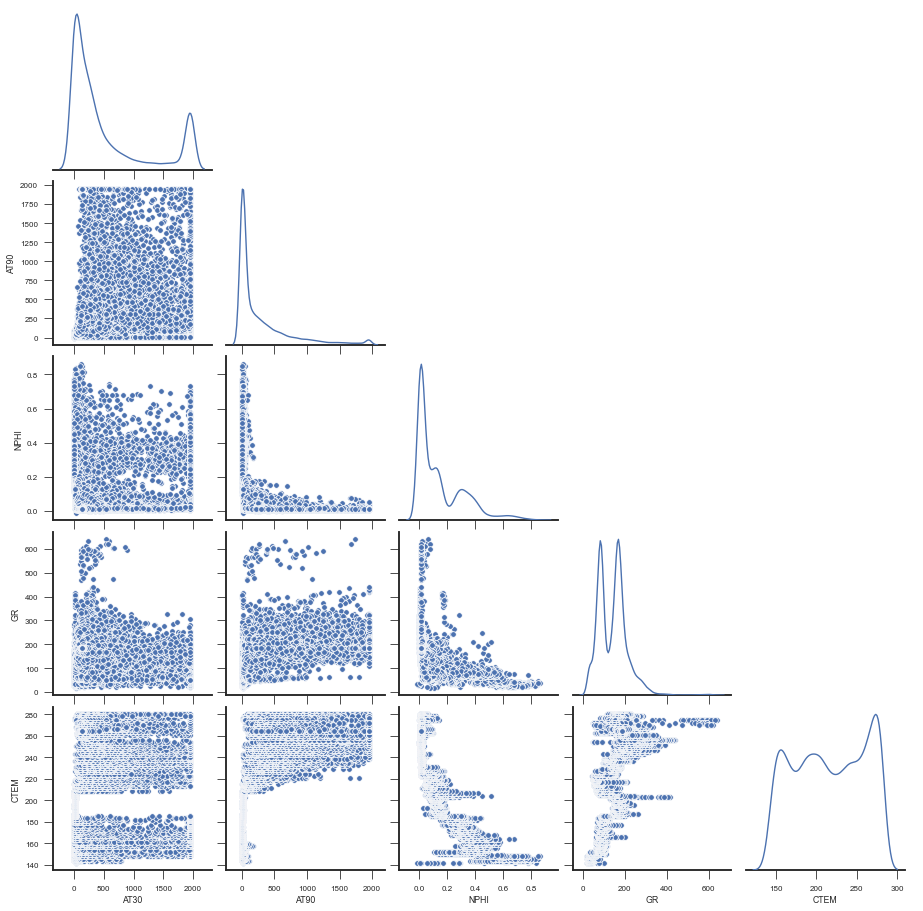

In [33]:
sns.set(style="ticks", context="talk")
plt.style.use('seaborn-paper')
g = sns.PairGrid(logs4_reg.iloc[:,1:], diag_sharey=False, corner=True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot)
g.add_legend()

#### Regression method

In [34]:
#Load data table for regression
logs4_reg.head()

,AT10,AT30,AT90,NPHI,GR,CTEM
18.5,1.1898,28.0289,19.7369,0.2883,19.2948,141.8353
19.0,1.1898,28.0289,19.7369,0.1305,22.6912,141.8353
19.5,1.1898,28.0289,19.7369,0.0787,24.8033,141.8353
20.0,1.1898,28.0289,19.7369,0.1451,31.8819,141.8353
20.5,1.1898,28.0289,19.7369,0.2495,33.7944,141.8353


Text(0.5, 1.0, 'hp')

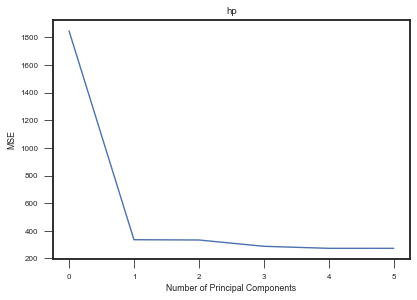

In [37]:
#Fit the PRC Model
#define predictor and response variables
X = pd.DataFrame(columns=cols[:-1], data=sc.fit_transform(logs4_reg.drop(cols[-1],axis=1)))
X.head()
y = logs4_reg.iloc[:, -1].values

#scale predictor variables
pca = PCA()
X_reduced = pca.fit_transform(scale(X))

#define k-fold cross validation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept
#MSE = Mean Square Error
score = -1*model_selection.cross_val_score(regr,
           np.ones((len(X_reduced),1)), y, cv=cv,
           scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using cross-validation, adding one component at a time
for i in np.arange(1, 6):
    score = -1*model_selection.cross_val_score(regr,
               X_reduced[:,:i], y, cv=cv, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
# Plot cross-validation results    
plt.plot(mse)
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.title('hp')

# The plot displays the number of principal components along the x-axis and the test MSE (mean squared error) along the y-axis

#### From plot we can see that the MSE decreses by adding in one component, yet it stabilizes as we add more than two pricipal components.

#### Thus the optimal model includes just the ?? pricipal components.

In [39]:
# Calculate the percentage of variance in the response variable explained by adding in each principal component to the model:

np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)


array([ 53.88,  75.63,  86.37,  95.85, 100.  ])

###### By using just the first principal component, we can explain 53.88% of the variation in the response variable.
###### By adding in the second principal component, we can explain 75.63% of the variation in the response variable.
Note that we’ll always be able to explain more variance by using more principal components, but we can see that adding in more than two principal components doesn’t actually increase the percentage of explained variance by much.

#### Use the Final Model to Make Predictions

In [40]:
#split the original dataset into a training and testing set and use the PCR model with X (two in this case) principal components to make predictions on the testing set

#split the dataset into training (70%) and testing (30%) sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0) 

#scale the training and testing data
X_reduced_train = pca.fit_transform(scale(X_train))
X_reduced_test = pca.transform(scale(X_test))[:,:1]

#train PCR model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:1], y_train)

#calculate RMSE
pred = regr.predict(X_reduced_test)
np.sqrt(mean_squared_error(y_test, pred))

18.254477685085146

We can see that the test RMSE turns out to be 18.2545. This is the average deviation between the predicted value for hp and the observed value for hp for the observations in the testing set.